In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import joblib
import os
import matplotlib.pyplot as plt

In [16]:
torch.manual_seed(28)
np.random.seed(28)

In [17]:
# Load and Prepare Data
print("Loading dataset...")
df = pd.read_csv("../data/qqq_supervised.csv", index_col=0, parse_dates=True)

feature_cols = [col for col in df.columns if col != 'Target' and not col.endswith("Return")]
X = df[feature_cols]
y = df['Target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "../models/day8_lstm_scaler.pkl")

# Create sequences
SEQ_LEN = 20
X_seq = []
y_seq = []
for i in range(SEQ_LEN, len(X_scaled)):
    X_seq.append(X_scaled[i-SEQ_LEN:i])
    y_seq.append(y.iloc[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print(f"Shape: X_seq = {X_seq.shape}, y_seq = {y_seq.shape}")

Loading dataset...
Shape: X_seq = (1462, 20, 35), y_seq = (1462,)


In [18]:
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [19]:
# PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TimeSeriesDataset(X_train, y_train)
test_ds = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [20]:
# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return self.sigmoid(out)

input_dim = X_seq.shape[2]
model = LSTMClassifier(input_dim=input_dim, hidden_dim=64, num_layers=2)

In [21]:
# Training
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 15
train_losses = []

print("\nTraining started...")
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f}")


Training started...
Epoch 1/15 | Loss: 17.3327
Epoch 2/15 | Loss: 7.6938
Epoch 3/15 | Loss: 5.9227
Epoch 4/15 | Loss: 3.8796
Epoch 5/15 | Loss: 3.1975
Epoch 6/15 | Loss: 2.7432
Epoch 7/15 | Loss: 2.3340
Epoch 8/15 | Loss: 2.2124
Epoch 9/15 | Loss: 2.0859
Epoch 10/15 | Loss: 1.9122
Epoch 11/15 | Loss: 1.9621
Epoch 12/15 | Loss: 1.6853
Epoch 13/15 | Loss: 1.4901
Epoch 14/15 | Loss: 2.2133
Epoch 15/15 | Loss: 1.4568


In [22]:
# Evaluation 
model.eval()
preds = []
true = []
with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb).squeeze()
        preds += list((out > 0.5).int().numpy())
        true += list(yb.int().numpy())

acc = accuracy_score(true, preds)
print(f"\nTest Accuracy: {acc * 100:.2f}%")
print("\nClassification Report:\n", classification_report(true, preds))


Test Accuracy: 94.54%

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83        46
           1       0.97      0.96      0.97       247

    accuracy                           0.95       293
   macro avg       0.89      0.91      0.90       293
weighted avg       0.95      0.95      0.95       293



In [23]:
# Save Model
os.makedirs("../models", exist_ok=True)
torch.save(model.state_dict(), "../models/day8_lstm_model.pt")
print("Saved model to ../models/day8_lstm_model.pt")

Saved model to ../models/day8_lstm_model.pt


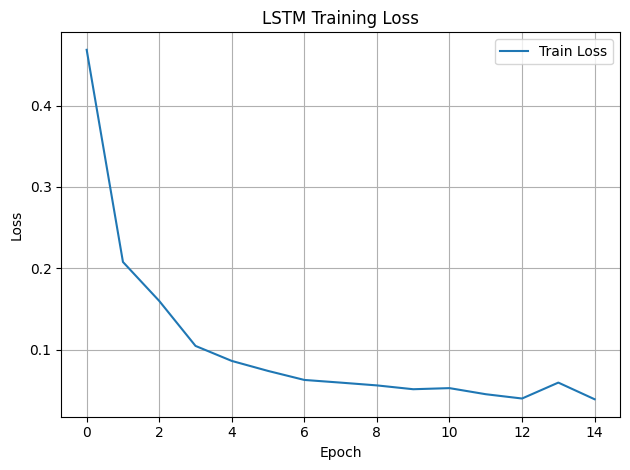

In [24]:
# Plotting Training Loss
plt.plot(train_losses, label="Train Loss")
plt.title("LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../figures/day8_lstm_loss.png", dpi=300)
plt.show()